# Survey Propagation at zero temperature

In [48]:
include("../code/sp.jl")
include("../code/slim_graphs.jl")
include("../code/headers.jl")
using StaticArrays, OffsetArrays, BenchmarkTools, DelimitedFiles

In [16]:
H = readgraph("/tmp/graph900.txt")
H = readseeds("/tmp/seeds900.txt", H)
M,N = size(H)
rowperm,colperm = leaf_removal(H);

size(H) = (660, 900)
1 removed factors [56]


In [45]:
fg = ldpc_graph(Val(2), 10000, 5000)
H = fg.H;

## Run on an instance

In [57]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 10
# init=OffsetArray(MVector{2J+1}([abs(j)<5 ? rand() : -1e3*rand() for j in -J:J]), -J:J)
init=OffsetArray(MVector{2J+1}(randn(2J+1)), -J:J)
sp = survey_propagation(H; field=s, init, y=Inf);

In [58]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration_zeroT_random!(sp, maxiter=50, callback=callback, damp=0.5, rein=0.0, tol=1e-15)

1 Inf
2 Inf
3 Inf
4 Inf
5 Inf
6 Inf
7 Inf
8 Inf
9 Inf
10 Inf
11 Inf
12 Inf
13 Inf
14 Inf
15 Inf
16 Inf
17 Inf
18 Inf
19 Inf
20 Inf
21 Inf
22 Inf
23 Inf
24 Inf
25 Inf
26 Inf
27 Inf
28 Inf
29 Inf
30 Inf
31 Inf
32 Inf
33 Inf
34 Inf
35 Inf
36 Inf
37 Inf
38 Inf
39 Inf
40 Inf
41 Inf
42 Inf
43 Inf
44 Inf
45 Inf
46 Inf
47 Inf
48 Inf
49 Inf
50 Inf


In [59]:
sp.Q[1];

In [60]:
sp.survey[1]

21-element OffsetArray(::Array{Float64,1}, -10:10) with eltype Float64 with indices -10:10:
 -Inf
  -2.1925010645418475
  -4.793231470017026
  -7.138329761260387
  -4.143119875883865
  -6.4882181671272265
  -4.166060923604661
  -6.511159214848022
  -8.078844199738562
 -11.628292761705778
 -11.391474629075088
  -9.918159982324518
  -7.681341849693826
 -10.863988679043057
  -8.627170546412366
  -6.213877084909896
  -3.9770589522792053
  -2.2368181326306917
   0.0
  -2.1496014087645925
 -Inf

In [61]:
σ = sign.(argmax.(sp.survey))
D = sum(σ .!= sp.efield)/size(sp.H,2)
x = (1 .- σ).÷2
z = sp.H*x .% 2
n_unsat = sum(z)
(n_unsat, D)

(2565, 0.5878)

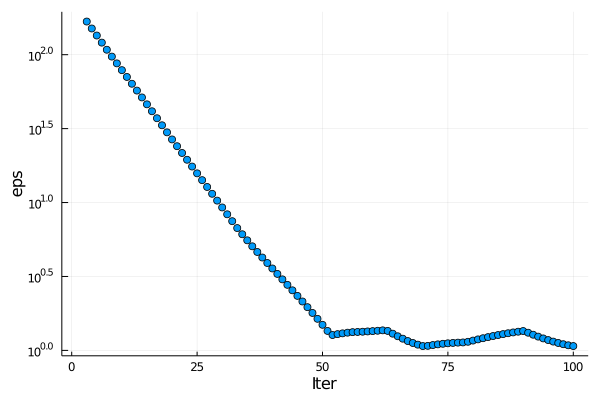

In [583]:
using Plots
to_plot = readdlm("sp_zeroT_data2.txt", Float64)
scatter(to_plot[:,1], to_plot[:,2], xlabel="Iter", ylabel="eps", yaxis=:log, label="")

In [603]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 100
init=OffsetArray(MVector{2J+1}(randn(2J+1)), -J:J)
sp = survey_propagation(H; field=s, init, y=Inf)
callback(t, ε, sp) = (println("$t $ε"); false)
iteration_zeroT_random!(sp, maxiter=100, callback=callback, damp=0.9, rein=0.0)

1 Inf
2 Inf
3 164.36219519340943
4 147.7442782812018
5 132.9288645831674
6 119.5813551419877
7 107.54498131961098
8 96.7159990053997
9 86.97910182729986
10 78.40675939381602
11 70.74653882454433
12 63.84564325885708
13 57.6241274451005
14 52.03947669022145
15 47.057907999650666
16 42.64766292948963
17 38.67489513827118
18 35.09340009867796
19 31.93548847351505
20 29.116242284021183
21 26.659081342326346
22 24.443575053562313
23 22.489464760098485
24 20.75235782701344
25 19.22220333580495
26 17.914152643938706
27 16.74009967362241
28 15.706182824657105
29 14.835252442578621
30 14.064965709826481
31 13.414519201430608
32 12.916725293096903
33 12.39373155230112
34 12.064822481651646
35 11.751159855225382
36 11.548530729852075
37 11.406608448501203
38 11.330878727368031
39 11.236703536774257
40 11.391128033512985
41 11.405629799597477
42 11.567833914492667
43 11.758761238551955
44 12.022210284940172
45 12.273407101330264
46 12.458100399893084
47 12.786975881949104
48 13.263585869251074
49 

LoadError: InterruptException:

In [563]:
H = sp.H
freevars = collect(1:size(H,2))
amax = argmax.(sp.survey)
σ = sign.(amax)
x = (1 .- σ).÷2
σ2 = sign.(argmax.([[s[i] for i in eachindex(s) if i != amax] for s in sp.survey]))
mag = abs.(σ-σ2)
[sort(freevars, by=i->abs(mag[i])) sort(mag)]

9000×2 Array{Int64,2}:
 7053  0
 7070  0
 3890  0
 7065  0
 7064  0
 7063  0
 3894  0
 7062  0
 7060  0
 7058  0
 3900  0
 3903  0
 3904  0
    ⋮  
 3980  2
 4001  2
 4000  2
 3997  2
 3994  2
 3991  2
 3989  2
 3988  2
 3987  2
 3986  2
 3985  2
 9000  2

In [ ]:
function decimate_zeroT!(sp; decsteps=10)
    H = sp.H
    freevars = collect(1:size(H,2))
    iteration_zeroT!(sp, maxiter=500, tol=1e-5, callback=callback, damp=0.5)
    while !isempty(freevars)
        iteration_zeroT!(sp, maxiter=100, tol=1e-3, damp=0.5)
        amax = argmax.(sp.survey)
        σ = sign.(amax)
        x = (1 .- σ).÷2
        σ2 = sign.(argmax.([[s[i] for i in eachindex(s) if i != amax] for s in sp.survey]))
        mag = maximum(abs, σ-σ2)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps):end]
        println("fixing: $tofix")
        sp.efield[tofix] .= sp.J.*x[tofix]
        x = Vector(mag .< 0)
        x1 = (B*x[indep]) .% 2
        println("$(sum(H*x .%2)) $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x)) $(length(freevars)/length(indep))")
    end
end

decimate!(sp; decsteps=50)

## Updates for variables and factors

In [537]:
b = 21
∂b = nonzeros(sp.X)[nzrange(sp.X, b)]
sp = deepcopy(sp1)
sp2 = deepcopy(sp1)
e1 = update_factor_zeroT_slow!(sp1, b; damp = 0.4)
e2 = update_factor_zeroT!(sp2, b; damp = 0.4)
[sp1.P[∂b][2] sp2.P[∂b][2]]
e1, e2

(0.0024268540099119384, 0.0024268540099119384)

In [405]:
@btime update_factor_zeroT_slow!($sp1, $b; damp = 0.4)

  1.757 ms (15907 allocations: 499.23 KiB)


4.440892098500626e-16

In [406]:
@btime update_factor_zeroT!($sp1, $b; damp = 0.4)

  17.384 μs (124 allocations: 16.98 KiB)


4.440892098500626e-16

In [538]:
i = 56
∂i = nzrange(sp.H, i)
sp = deepcopy(sp1)
e1 = update_var_zeroT_slow!(sp1, i; damp = 0.1, rein = 0.1)
e2 = update_var_zeroT!(sp, i; damp = 0.1, rein = 0.1)
[sp1.survey[i] sp.survey[i]]
[sp1.Q[∂i][2] sp.Q[∂i][2]]
# e1,e2

21×2 Array{Float64,2}:
 -Inf          -Inf
  -5.15958      -5.15958
  -2.66215      -2.66215
  -4.4489       -4.4489
  -4.26628      -4.26628
  -5.2689       -5.2689
  -3.21545      -3.21545
  -3.59403      -3.59403
  -4.17784      -4.17784
  -7.12606      -7.12606
  -5.93311      -5.93311
  -3.05381      -3.05381
  -2.40991      -2.40991
  -2.69495      -2.69495
  -1.92697      -1.92697
  -2.7899       -2.7899
  -2.95291      -2.95291
  -2.42856      -2.42856
  -0.724338     -0.724338
   1.40845e-8    1.40845e-8
  -2.03067      -2.03067

In [455]:
@btime update_var_zeroT_slow!($sp1, $i; damp = 0.4, rein = 1e-3)

  297.501 μs (5349 allocations: 160.33 KiB)


8.881784197001252e-16

In [456]:
@btime update_var_zeroT!($sp1, $i; damp = 0.4, rein = 1e-3)

  5.886 μs (19 allocations: 3.72 KiB)


8.881784197001252e-16

## Recursion for the b's

In [356]:
Q = [OffsetArray(randn(2J+1),-J:J) for _ in 1:3];

In [357]:
function Bslow(Q; k=length(Q)-1)
   b = fill(-Inf, -J:J)
    for hs in Iterators.product(fill(-J:J, k)...)
        u = minimum(abs, hs)
        σ = prod(sign, hs)
        for v in 1:u
           b[v*σ] = max(b[v*σ], sum(q[h] for (q,h) in zip(Q,hs))) 
        end
    end
    b
end

function Bfast(Q; k=length(Q)-1)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    for n in 1:k
        for u in 1:J
            m1 = maximum(Q[n][u:end])
            m2 = maximum(Q[n][begin:-u])
            bnew[u] = max(m1+b[u], m2+b[-u])
            bnew[-u] = max(m1+b[-u], m2+b[u])
        end
        b .= bnew
    end
    b
end

Bfast (generic function with 1 method)

In [358]:
Bsl = Bslow(Q)
Bfa = Bfast(Q)
Bsl == Bfa

true

## Recursion for the a's

In [388]:
Q = [OffsetArray(rand(2J+1),-J:J) for _ in 1:2];

In [389]:
function Aslow(Q; k=length(Q))
    a = fill(-Inf, -J:J)
    for hs in Iterators.product(fill(-J:J, k)...)
        u = minimum(abs, hs)*prod(sign, hs)
        a[u] = max(a[u], sum(q[h] for (q,h) in zip(Q,hs))) 
    end
    a
end

function Pifast(Q)
    a = Aslow(Q, k=length(Q)-1)
    b = Bslow(Q, k=length(Q)-1)
    p = fill(-Inf, -J:J)
    q = Q[end]
    for u in 1:J-1
        m1 = maximum(q[u+1:end])
        m2 = maximum(q[begin:-u-1])
        p[u] = max(q[u]+b[u], q[-u]+b[-u], m1+a[u], m2+a[-u])
        p[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+a[-u], m2+a[u])
    end
    p[J] = max(q[J]+b[J], q[-J]+b[-J])
    p[-J] = max(q[J]+b[-J], q[-J]+b[J])
    # u=0
    sumqstar = 0.0
    qmax = -Inf
    for j in 1:length(Q)
        qstar = maximum(Q[j])
        sumqstar += qstar
        qmax = max(qmax, Q[j][0] - qstar)
    end
    p[0] = sumqstar + qmax
    p
end
    
function Afast(Q, k=length(Q))
    p = fill(-Inf, -J:J)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    pnew = fill(-Inf, -J:J)
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    sumqstar = 0.0
    qmax = -Inf
    for j in 1:k
        q = Q[j]
        # update for u=0
        qstar = maximum(q)
        sumqstar += qstar
        qmax = max(qmax, q[0] - qstar)
        # update p and b
        for u in 1:J-1
            m1 = maximum(q[u+1:end])
            m2 = maximum(q[begin:-u-1])
            pnew[u] = max(q[u]+b[u], q[-u]+b[-u], m1+p[u], m2+p[-u])
            pnew[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+p[-u], m2+p[u])
            n1 = max(m1, q[u])
            n2 = max(m2, q[-u])
            bnew[u] = max(n1+b[u], n2+b[-u])
            bnew[-u] = max(n1+b[-u], n2+b[u])
        end
        pnew[J] = bnew[J] = max(q[J]+b[J], q[-J]+b[-J])
        pnew[-J] = bnew[-J] = max(q[J]+b[-J], q[-J]+b[J])
        b .= bnew
        p .= pnew
    end
    p[0] = sumqstar + qmax
    p        
end
    
function Afast_old(Q, k=length(Q))
    a = fill(-Inf, -J:J)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    anew = fill(-Inf, -J:J)
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    for n in 1:k
        q = Q[n]
        # update a
        for u in 1:J-1
            m1 = maximum(q[u+1:end])
            m2 = maximum(q[begin:-u-1])
            anew[u] = max(q[u]+b[u], q[-u]+b[-u], m1+a[u], m2+a[-u])
            anew[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+a[-u], m2+a[u])
        end
        anew[J] = max(q[J]+b[J], q[-J]+b[-J])
        anew[-J] = max(q[J]+b[-J], q[-J]+b[J])
        # update b
        for u in 1:J
            m1 = maximum(q[u:end])
            m2 = maximum(q[begin:-u])
            bnew[u] = max(m1+b[u], m2+b[-u])
            bnew[-u] = max(m1+b[-u], m2+b[u])
        end
        b .= bnew
        a .= anew
    end
    a        
end

Afast_old (generic function with 2 methods)

In [390]:
Asl = Aslow(Q, k=length(Q))
Pfast = Pifast(Q)
Afa = Afast(Q)
[Asl Pfast Afa]

21×3 Array{Float64,2}:
 0.999569  0.999569  0.999569
 1.18077   1.18077   1.18077
 1.50147   1.50147   1.50147
 1.76321   1.76321   1.76321
 1.5637    1.5637    1.5637
 1.70259   1.70259   1.70259
 1.78917   1.78917   1.78917
 1.83508   1.83508   1.83508
 1.63741   1.63741   1.63741
 1.73482   1.73482   1.73482
 1.67677   1.67677   1.67677
 1.77491   1.77491   1.77491
 1.61045   1.61045   1.61045
 1.80812   1.80812   1.80812
 1.77844   1.77844   1.77844
 1.79017   1.79017   1.79017
 1.47612   1.47612   1.47612
 1.67563   1.67563   1.67563
 1.59641   1.59641   1.59641
 1.14453   1.14453   1.14453
 1.07134   1.07134   1.07134

## Max-Sum convolution for variable update

In [231]:
function msc_slow(P, J=10, s=1)
    Pnew = copy(P[2:end])
    f = min(-J, sum(firstindex(p) for p in Pnew)+s)
    l = max(J,sum(lastindex(p) for p in Pnew)+s)
    q = fill(Inf, f:l)
    for us in Iterators.product(fill(-J:J, length(Pnew))...)
        h = sum(us) + s
        q[h] = min(q[h],abs(h) - sum(abs.(u)+p[u] for (p,u) in zip(Pnew,us)))
    end
    replace!(q, Inf => -Inf)
    # clamp
    q[J] = maximum(q[J:end])
    q[-J] = maximum(q[begin:-J])
    q[-J:J]
end

function msc_fast(P, J=10, s=1)
    Pnew = [abs.(OffsetArray(-J:J, -J:J)) + p for p in P[2:end]]
    f = fill(0.0, s:s)
    for n in eachindex(Pnew)
        f = msc(f, Pnew[n])
    end  
    q = fill(-Inf, -J:J)
    for h in eachindex(f)
        q[clamp(h,-J,J)] = max(q[clamp(h,-J,J)], abs(h) - f[h])
    end
        @show q_fast=q
    q  
end
    
function msc_faster(P, J=10, s=1)
    Pnew = [abs.(OffsetArray(-J:J, -J:J)) + p for p in P[2:end]]
    init = fill(0.0, s:s)
    Q = [fill(0.0, 0:0) for a ∈ 1:length(Pnew)]
    f = cavity!(Q, Pnew, msc, init)
    q = fill(-Inf, -J:J)
    for h in eachindex(f)
        q[clamp(h,-J,J)] = max(q[clamp(h,-J,J)], abs(h) - f[h])
    end
    @show q_faster = q
    q
end

msc_faster (generic function with 3 methods)